In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:

df = pd.read_csv("../data/measurements.csv")


In [3]:
num_cols = df.columns[df.columns != "name"]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

df

,name,1-L,1-W,1-H,2-L,2-W,2-H,3-L,3-W,3-H,T-L,T-W,T-H
0,mic box,245.29,126.93,87.06,245.66,126.91,87.55,245.63,126.70,87.59,245.0,127.6,83.0
1,remote,174.34,40.99,21.54,174.44,39.98,20.73,173.98,40.40,21.51,172.0,43.0,23.0
2,capybara,140.23,91.41,119.45,140.17,97.43,120.17,141.30,97.97,119.55,151.0,104.8,123.0
3,mouse,116.93,75.44,48.66,116.16,76.08,48.34,116.48,75.51,48.47,112.0,80.2,49.3
4,multimeter,128.70,75.43,30.35,128.52,75.55,31.24,128.85,75.67,31.24,125.1,69.2,27.0
5,cake,110.77,78.74,28.46,108.86,78.71,28.90,110.32,80.70,26.65,107.1,82.0,27.6
6,plate,179.43,172.81,43.23,179.54,171.39,44.13,177.31,171.82,45.00,177.0,177.0,44.0
7,toolbox,277.68,229.20,89.54,277.91,229.26,89.51,278.26,229.27,89.73,270.0,230.0,87.3


In [4]:

dims = ["L", "W", "H"]
out = df[["name"]].copy()

for d in dims:
    meas = [f"1-{d}", f"2-{d}", f"3-{d}"]
    true = f"T-{d}"
    out[f"mean_{d}"] = df[meas].mean(axis=1)
    out[f"std_{d}_pct"] = df[meas].std(axis=1) / df[true] * 100
    out[f"err_{d}_pct"] = (out[f"mean_{d}"] - df[true]).abs() / df[true] * 100

out

,name,mean_L,std_L_pct,err_L_pct,mean_W,std_W_pct,err_W_pct,mean_H,std_H_pct,err_H_pct
0,mic box,245.526667,0.083881,0.214966,126.846667,0.099851,0.590387,87.400000,0.355575,5.301205
1,remote,174.253333,0.140661,1.310078,40.456667,1.179951,5.914729,21.260000,1.996689,7.565217
2,capybara,140.566667,0.421055,6.909492,95.603333,3.474768,8.775445,119.723333,0.317108,2.663957
3,mouse,116.523333,0.345379,4.038690,75.676667,0.437713,5.640067,48.490000,0.326440,1.643002
4,multimeter,128.690000,0.132076,2.869704,75.550000,0.173410,9.176301,30.943333,1.903118,14.604938
5,cake,109.983333,0.932321,2.692188,79.383333,1.390690,3.191057,28.003333,4.320617,1.461353
6,plate,178.760000,0.710136,0.994350,172.006667,0.411396,2.821092,44.120000,2.011460,0.272727
7,toolbox,277.950000,0.108171,2.944444,229.243333,0.016461,0.328986,89.593333,0.136659,2.626957


In [5]:
out_long = (
    out.melt(id_vars="name", var_name="metric_dim", value_name="value")
    .assign(
        metric=lambda frame: frame["metric_dim"].str.extract(r"^(mean|std|err)")[0],
        dim=lambda frame: frame["metric_dim"].str.extract(r"_([LWH])")[0],
        unit=lambda frame: frame["metric_dim"].str.endswith("_pct").map({True: "pct", False: "mm"}),
    )
    .dropna(subset=["metric", "dim"])
    .drop(columns="metric_dim")
    .sort_values(["name", "dim", "metric"])
    .reset_index(drop=True)
)

out_long.head(12)

,name,value,metric,dim,unit
0,cake,1.461353,err,H,pct
1,cake,28.003333,mean,H,mm
2,cake,4.320617,std,H,pct
3,cake,2.692188,err,L,pct
4,cake,109.983333,mean,L,mm
5,cake,0.932321,std,L,pct
6,cake,3.191057,err,W,pct
7,cake,79.383333,mean,W,mm
8,cake,1.390690,std,W,pct
9,capybara,2.663957,err,H,pct


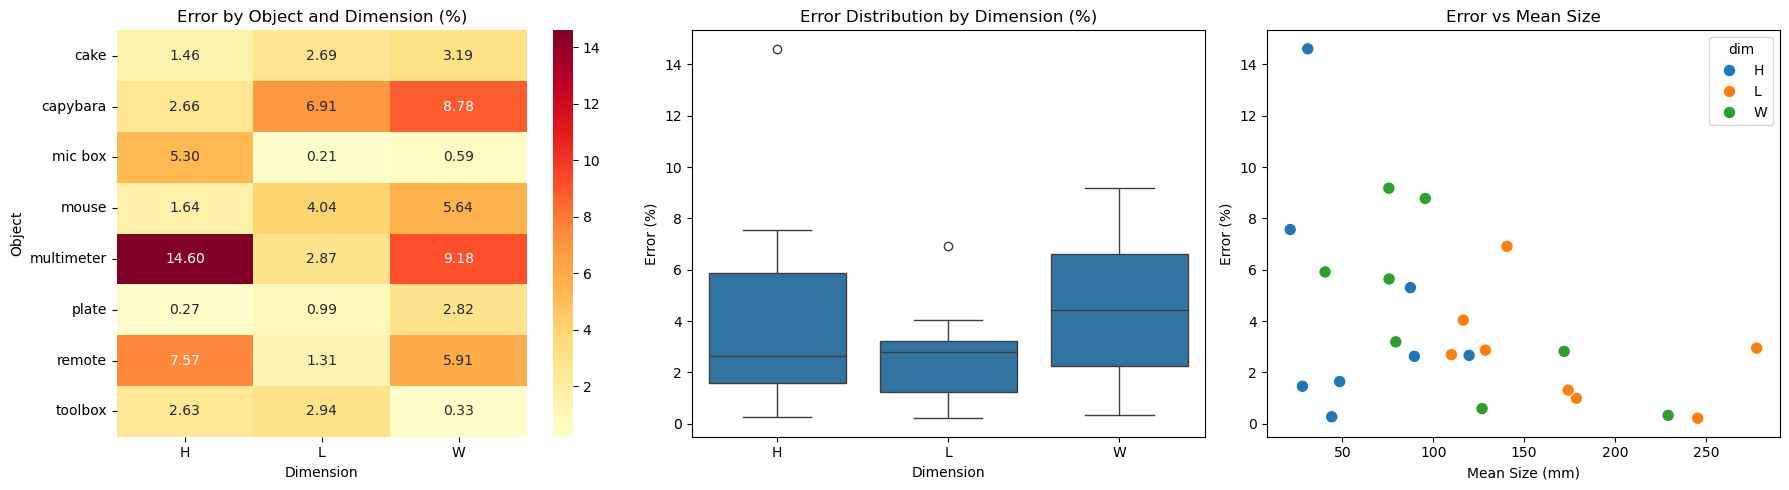

In [6]:
err_long = out_long.query("metric == 'err'").copy()
std_long = out_long.query("metric == 'std'").copy()
mean_long = out_long.query("metric == 'mean'").copy()

err_long = err_long.rename(columns={"value": "err_pct"})
std_long = std_long.rename(columns={"value": "std_pct"})
mean_long = mean_long.rename(columns={"value": "mean_mm"})

scatter_df = mean_long[["name", "dim", "mean_mm"]].merge(
    err_long[["name", "dim", "err_pct"]],
    on=["name", "dim"],
    how="inner",
)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

heatmap_df = err_long.pivot(index="name", columns="dim", values="err_pct")
sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap="YlOrRd", ax=axes[0])
axes[0].set_title("Error by Object and Dimension (%)")
axes[0].set_xlabel("Dimension")
axes[0].set_ylabel("Object")

sns.boxplot(data=err_long, x="dim", y="err_pct", ax=axes[1])
axes[1].set_title("Error Distribution by Dimension (%)")
axes[1].set_xlabel("Dimension")
axes[1].set_ylabel("Error (%)")

sns.scatterplot(data=scatter_df, x="mean_mm", y="err_pct", hue="dim", s=80, ax=axes[2])
axes[2].set_title("Error vs Mean Size")
axes[2].set_xlabel("Mean Size (mm)")
axes[2].set_ylabel("Error (%)")

plt.tight_layout()
plt.show()